In [1]:
words = open('names.txt','r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
len(words), min(len(word) for word in words), max(len(word) for word in words)

(32033, 2, 15)

In [13]:
dictn = {}

for word in words:
  chs = ['<S>'] + list(word) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    dictn[bigram] = dictn.get(bigram, 0) + 1


sorted(dictn.items(), key =lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [31]:
import torch
N = torch.zeros((27,27), dtype = torch.int32)

In [37]:
chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c,i in ctoi.items()}

for word in words:
  chs = ['.'] + list(word) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = ctoi[ch1]
    ix2 = ctoi[ch2]
    N[ix1, ix2] += 1

In [38]:
ctoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

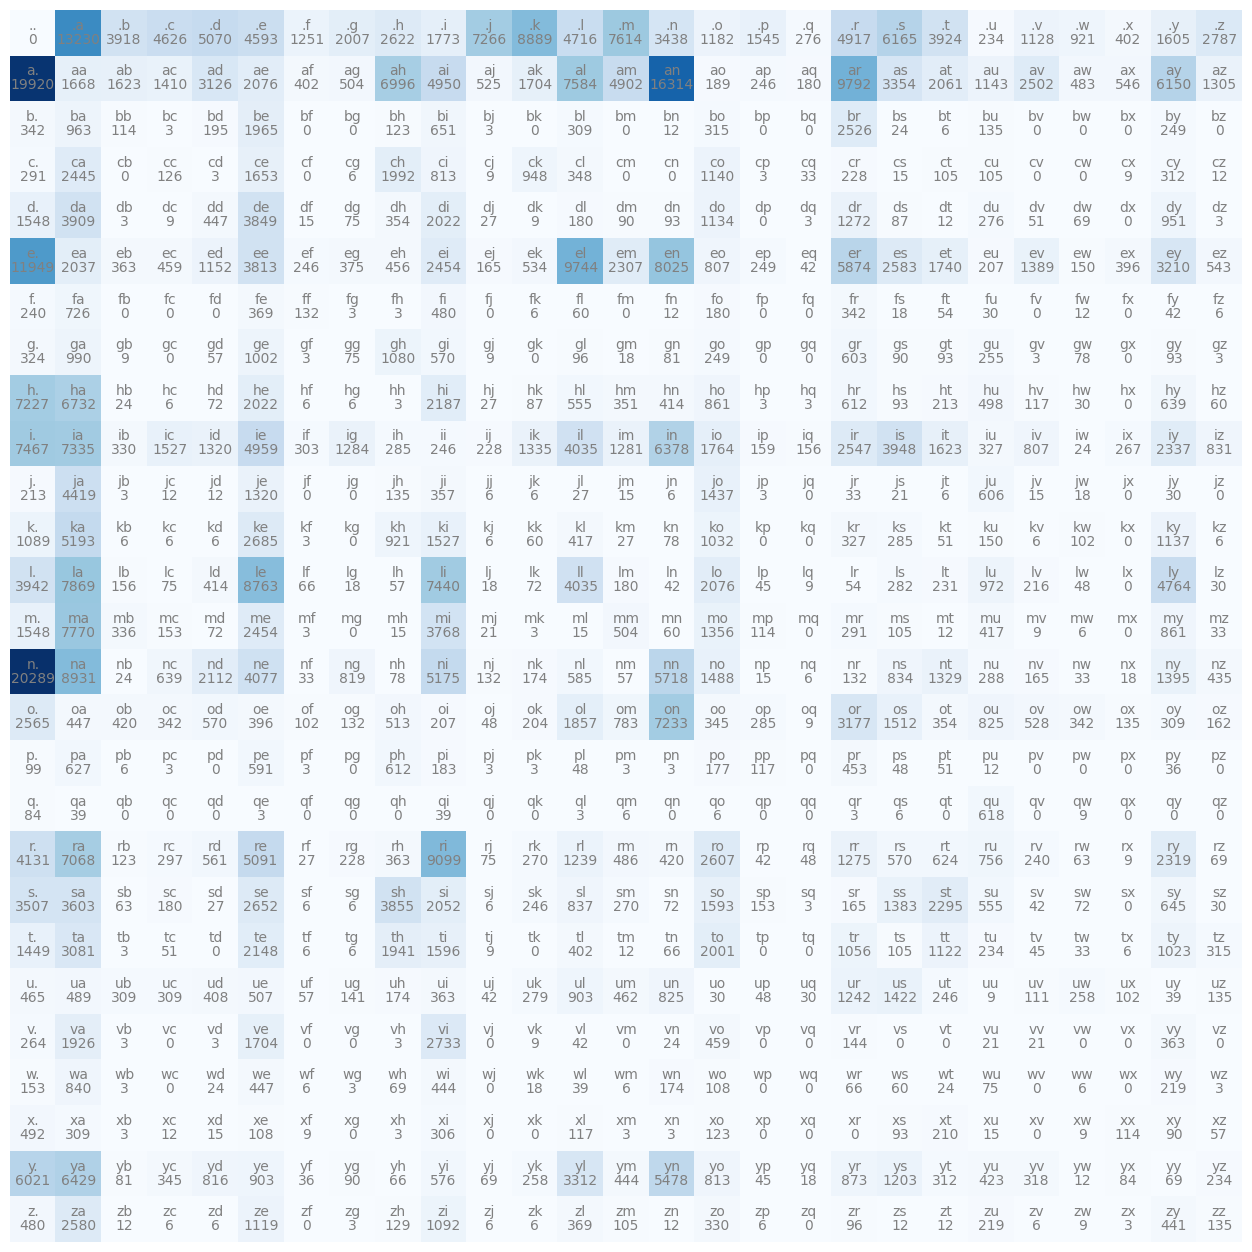

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itoc[i] + itoc[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [50]:
N[0, :]
#  == N[0]

tensor([    0, 13230,  3918,  4626,  5070,  4593,  1251,  2007,  2622,  1773,
         7266,  8889,  4716,  7614,  3438,  1182,  1545,   276,  4917,  6165,
         3924,   234,  1128,   921,   402,  1605,  2787], dtype=torch.int32)

In [72]:
P = (N+1).float() #model smoothing
P /= P.sum(1, keepdim=True)

In [60]:
g = torch.Generator().manual_seed(2147483647)

out = []
for _ in range(10):
  str = []
  ix = 0
  while True:
    p = P[ix]
    # p = N[ix].float()
    # p = p / p.sum()
    #p = torch.ones(27) / 27.0

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    str.append(itoc[ix])
    if ix == 0:
      break
  out.append(''.join(str))

for i in range(10):
  print(out[i])

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [71]:
log_likelihood = 0.0
n = 0

for word in words:
  chs = ['.'] + list(word) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = ctoi[ch1]
    ix2 = ctoi[ch2]
    prob = P[ix1, ix2]
    likelihood = torch.log(prob)
    log_likelihood += likelihood
    n += 1
    # print(f'{ch1}{ch2}: {prob:.4f} {likelihood:.4f}')

print(f'll : {log_likelihood:.4f}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

ll : -559891.7500
nll=tensor(559891.7500)
2.454094171524048


In [75]:
#create the training set of bigram (x, y)

xs, ys = [], []

for word in words[:1]:
  chs = ['.'] + list(word) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = ctoi[ch1]
    ix2 = ctoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs, ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

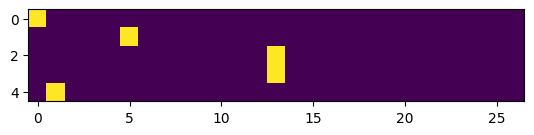

In [78]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
plt.imshow(xenc)

In [79]:
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [85]:
g = torch.Generator().manual_seed(2147483647)
w = torch.randn ((27, 27), generator = g)
xenc @ w

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9643e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0730e-02,
          2.4968e+00,  2.4448e+00],
        [ 4.7236e-01,  1.4830e+00,  3.1748e-01,  1.0588e+00,  2.3982e+00,
          4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01,
          5.5570e-01,  4.7458e-01, -1.3867e+00,  1.6229e+00,  1.7197e-01,
          9.8846e-01,  5.0657e-01,  1.0198e+00, -1.9062e+00, -4.2753e-01,
         -2.1259e+00,  9.6041e-01],
        [ 1.9359e-01,  1.0532e+00,  6.3393e-01,  2.5786e-01,  9.6408e-01,
         -2.4855e-01,  2.4756e-02, -3.0404e-02,  1.5622e+00, -4.4852e-01,
         -1.2345e+00,  1.1220e+00, -6.73

In [86]:
logits = xenc @ w
counts = logits.exp() # eqv to N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

In [90]:
nlls = torch.zeros(5)
for i in range(5):
  #i-th bigram
  x = xs[i].item()
  y = ys[i].item()
  print('--------')
  print(f'input: {x}, target: {y}')
  print(f'input: {itoc[x]}, target: {itoc[y]}')
  print(f'output prob from the nn:', probs[i])
  p = probs[i, y]
  print(f'prob: {p.item():.4f}')
  logp = torch.log(p)
  print(f'logprob: {logp.item():.4f}')
  nll = -logp
  print(f'nll: {nll:.4f}')
  nlls[i] = nll

print(f'average nll (loss) : {nlls.mean().item()}')

--------
input: 0, target: 5
input: ., target: e
output prob from the nn: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
prob: 0.0123
logprob: -4.3993
nll: 4.3993
--------
input: 5, target: 13
input: e, target: m
output prob from the nn: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
prob: 0.0181
logprob: -4.0146
nll: 4.0146
--------
input: 13, target: 13
input: m, target: m
output prob from the nn: tensor([0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
        0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
        0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0

In [185]:
#create the dataset

xs, ys = [], []

for word in words:
  chs = ['.'] + list(word) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = ctoi[ch1]
    ix2 = ctoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [186]:
num = xs.nelement()
print(f'{num=}')
xs

num=228146


tensor([ 0,  5, 13,  ..., 25, 26, 24])

In [187]:
ys

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [188]:
#init the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn ((27, 27), generator = g, requires_grad=True)

In [190]:
#grad descent
for k in range(100):

  #forward pass
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc @ W
  counts = logits.exp() # eqv to N
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(num),ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None
  loss.backward()

  #update
  W.data += -50 * W.grad

2.4726526737213135
2.4724340438842773
2.4722204208374023
2.472010850906372
2.471806049346924
2.4716053009033203
2.471409320831299
2.4712166786193848
2.4710280895233154
2.4708433151245117
2.4706623554229736
2.4704854488372803
2.4703118801116943
2.4701414108276367
2.4699742794036865
2.4698104858398438
2.46964955329895
2.469492197036743
2.4693377017974854
2.4691860675811768
2.469036817550659
2.468891143798828
2.468747615814209
2.46860671043396
2.468468427658081
2.468332529067993
2.4681990146636963
2.4680681228637695
2.4679393768310547
2.4678127765655518
2.467688798904419
2.4675662517547607
2.4674463272094727
2.4673283100128174
2.467212438583374
2.467097759246826
2.4669857025146484
2.4668753147125244
2.466766834259033
2.4666595458984375
2.4665544033050537
2.466451406478882
2.4663491249084473
2.4662492275238037
2.4661502838134766
2.4660532474517822
2.4659576416015625
2.4658634662628174
2.4657704830169678
2.465679407119751
2.4655895233154297
2.465500593185425
2.4654135704040527
2.46532726287